#### Business Understanding:

The goal of this project is to identify an effective way to determine a person's Myers-Briggs Type Indicator (MBTI) based on their text posts. This can help in understanding personality traits from written text, which can be useful in various applications like targeted marketing, personalized content, and psychological research.  Several classification models will be trained (Naive Bayes, Logistic Regression, Decision Trees, SVC) to determine a person's MBTI from social media posts and comparing their performances to identify the best model.

#### Dataset Understanding:

The original dataset is from Kaggle (https://www.kaggle.com/datasets/datasnaek/mbti-type) contains over 8600 rows of data, on each row is a person’s:

- TYPE: The Myers-Briggs Type Indicator.
- POSTS: A section of each of the last 50 things they have posted (Each entry separated by "|||" (3 pipe characters)) along with the URL of the post (if any).

#### Import and Setup:

Libraries:

- Data handling: pandas
- Visualization: matplotlib, seaborn
- Text processing: nltk, re
- Machine learning: sklearn
- Sentence embeddings: sentence_transformers

In [137]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import time
import warnings
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.utils import resample
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sentence_transformers import SentenceTransformer

warnings.simplefilter(action='ignore')


In [138]:
# Download necessary NLTK resources
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /Users/aiml/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/aiml/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /Users/aiml/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/aiml/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [139]:
# # Load the data from the CSV file and display the first few rows to inspect
df = pd.read_csv('Data/mbti_1.csv')

# Display the first few rows
df.head()

,TYPE,POSTS
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired.|||That's another silly misconce...


#### Exploratory Data Analysis:

- Display dataset information and shape.
- Summarize data.
- Analyze unique MBTI types and their distribution.
- Analyze the length of posts.

In [140]:
# Display the dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8675 entries, 0 to 8674
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   TYPE    8675 non-null   object
 1   POSTS   8675 non-null   object
dtypes: object(2)
memory usage: 135.7+ KB


In [141]:
df.shape

(8675, 2)

In [142]:
# Summarize the data in dataset
# Display basic statistics for the columns
summary = df.describe(include='all')
print(summary)

        TYPE                                              POSTS
count   8675                                               8675
unique    16                                               8675
top     INFP  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
freq    1832                                                  1


In [143]:
# Find the unique values in the 'TYPE' column (this is the target variable).
type_unique = df['TYPE'].unique()
# Count the number of unique values
type_count = len(type_unique)
print('Number of unique values in TYPE column:', type_count,'\n')
# Print the unique values
print('Unique values in TYPE column:', type_unique)

Number of unique values in TYPE column: 16 

Unique values in TYPE column: ['INFJ' 'ENTP' 'INTP' 'INTJ' 'ENTJ' 'ENFJ' 'INFP' 'ENFP' 'ISFP' 'ISTP'
 'ISFJ' 'ISTJ' 'ESTP' 'ESFP' 'ESTJ' 'ESFJ']


In [166]:
# Display the first few rows of the 'POSTS' column to understand its content
posts_head = df['POSTS'].head()
print('First few rows of POSTS column: \n', posts_head)

First few rows of POSTS column: 
 0     'http://www.youtube.com/watch?v=qsxhcwe3krw|||...
6     'no, i can't draw on my own nails (haha). thos...
8     i'm not sure, that's a good question. the dist...
10    'one time my parents were fighting over my dad...
12    'joe santagato - entp|||enfj or  entp?   i'm n...
Name: POSTS, dtype: object


In [145]:
#summary statistics of POSTS length
df['char_count'] = df.POSTS.apply(len)
print('POSTS Mean character count:', df['char_count'].mean())
print('POSTS Min character count:', df['char_count'].min())
print('POSTS Max character count:', df['char_count'].max())

POSTS Mean character count: 7234.98962536023
POSTS Min character count: 57
POSTS Max character count: 10090


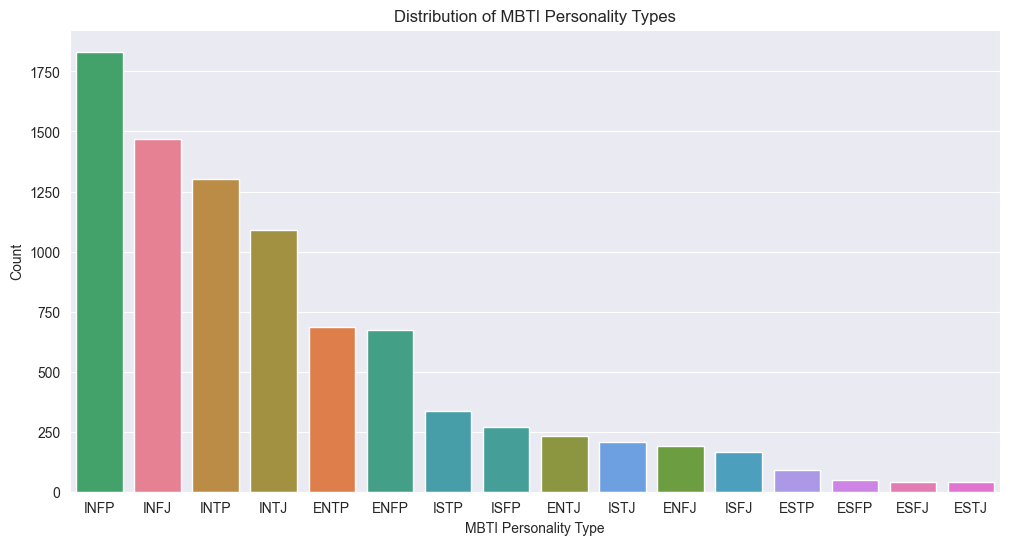

In [146]:
# Generate a graph that shows the distribution of MBTI personality types
# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create a count plot for the 'type' column
sns.countplot(x='TYPE', data=df, order=df['TYPE'].value_counts().index, hue='TYPE')

# Set the title and labels
plt.title('Distribution of MBTI Personality Types')
plt.xlabel('MBTI Personality Type')
plt.ylabel('Count')

# Display the plot
plt.show()

The distribution shows a significant imbalance among the MBTI personality types. This indicates a potential issue for machine learning models, as they might become biased towards the more prevalent classes.

Note: While working with the original 16 MBTI personality types, it was found that the models appeared overtaxing my local machine. Therefore, it was decided to reduce the number of personality types from 16 to the 2 most common, being INFP and INFJ. 

#### Data Cleaning and Pre-processing:

- Focus on the two most common MBTI types (INFP and INFJ) due to computational constraints.
- Convert text to lowercase.
- Parse POSTS into separate rows.
- Remove URLs, special characters, and numbers.
- Remove rows with empty POSTS values and unnecessary whitespace.

In [147]:
# Remove rows with TYPE values that are not 'INFP', 'INFJ'
df = df[df['TYPE'].isin(['INFP', 'INFJ'])]
df.shape

(3302, 3)

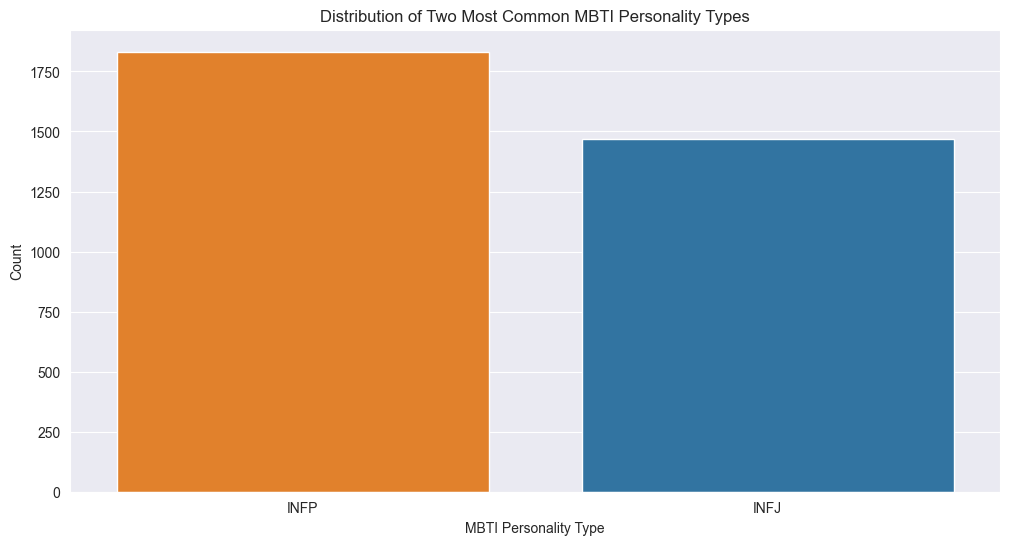

In [148]:
# Generate a graph that shows the distribution of MBTI personality types
# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create a count plot for the 'type' column
sns.countplot(x='TYPE', data=df, order=df['TYPE'].value_counts().index, hue='TYPE')

# Set the title and labels
plt.title('Distribution of Two Most Common MBTI Personality Types')
plt.xlabel('MBTI Personality Type')
plt.ylabel('Count')

# Display the plot
plt.show()

The counts for INFP and INFJ are relatively close, with INFP being slightly more common than INFJ. This suggests a better balance between these two classes compared to the previous graph with all MBTI types.

The focus on only two classes can be advantageous if the goal is to differentiate between INFP and INFJ specifically. However, this does not account for the diversity of all MBTI types, which might be necessary depending on the use case.

 The POSTS column contains text data separated by "|||" - these will need to be parsed out into separate rows. The POSTS column also contains URLs. Will we need to process this data to remove URL, special characters, and numbers. 

In [149]:
# Function to parse POSTS into separate rows and retain the same TYPE   
def parse_posts(row):
    posts = row['POSTS'].split('|||')
    return pd.DataFrame({'TYPE': [row['TYPE']] * len(posts), 'POSTS': posts})

# Convert text to lowercase
df['POSTS'] = df['POSTS'].str.lower()

# Parse posts into separate rows
parsed_df = pd.concat(df.apply(parse_posts, axis=1).to_list(), ignore_index=True)

# Remove URLs, special characters, and numbers
parsed_df['POSTS'] = parsed_df['POSTS'].apply(lambda x: re.sub(r'http\S+|www\S+|https\S+|[^a-zA-Z\s]', '', x))

# Remove rows with blank or empty POSTS values
parsed_df = parsed_df[parsed_df['POSTS'].str.strip().astype(bool)]

# Remove unnecessary whitespace
parsed_df['POSTS'] = parsed_df['POSTS'].apply(lambda x: ' '.join(x.split()).strip())

# Display the prepped data
print(parsed_df.head(), '\n')

# Display the size of the prepped data
print('Size of prepped data:', len(parsed_df), '\n')

# Print the size of the largest post
print('Size of largest post:', parsed_df['POSTS'].str.len().max())

   TYPE                                              POSTS
2  INFJ  enfp and intj moments sportscenter not top ten...
3  INFJ  what has been the most lifechanging experience...
4  INFJ                        on repeat for most of today
5  INFJ                may the perc experience immerse you
6  INFJ  the last thing my infj friend posted on his fa... 

Size of prepped data: 156170 

Size of largest post: 200


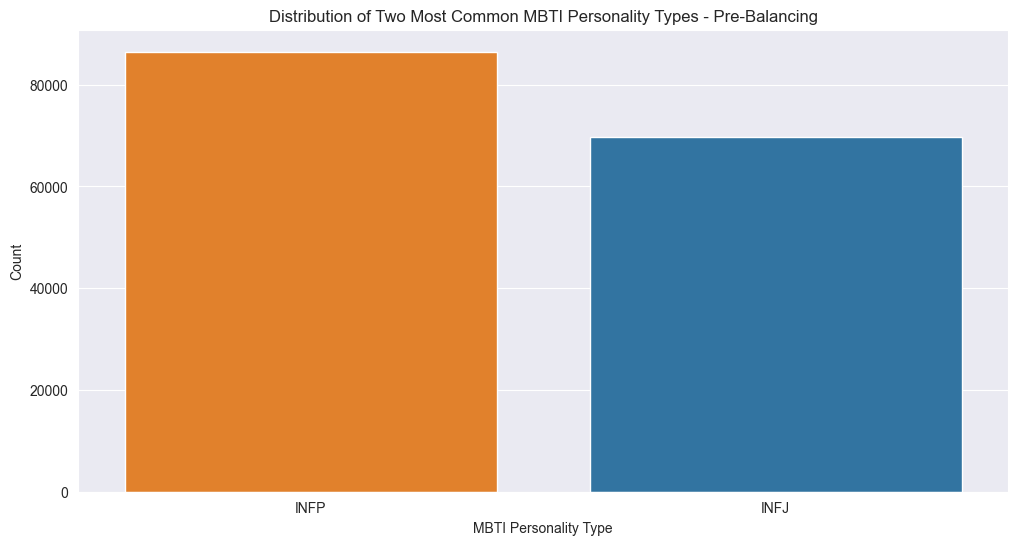

In [167]:
# Generate a graph that shows the distribution of MBTI personality types
# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create a count plot for the 'type' column
sns.countplot(x='TYPE', data=parsed_df, order=parsed_df['TYPE'].value_counts().index, hue='TYPE')

# Set the title and labels
plt.title('Distribution of Two Most Common MBTI Personality Types - Pre-Balancing')
plt.xlabel('MBTI Personality Type')
plt.ylabel('Count')

# Display the plot
plt.show()

The dataset has more than enough data to train the models we will reduce the dataset size and balance it to improve model performance.

In [151]:
# Reduce the dataset size and balance to improve model performance

# Separate the dataset by TYPE
parsed_df_0 = parsed_df[parsed_df['TYPE'] == 'INFP']
parsed_df_1 = parsed_df[parsed_df['TYPE'] == 'INFJ']

# Resample 5000 entries from each class
resampled_df_0 = resample(parsed_df_0, n_samples=5000, random_state=42)
resampled_df_1 = resample(parsed_df_1, n_samples=5000, random_state=42)

# Combine the resampled dataframes
balanced_df = pd.concat([resampled_df_0, resampled_df_1])

# Shuffle the balanced dataset
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

The dataset has been reduced in size and balanced to improve the model's performance. Let's visualize the distribution of the 'TYPE' column again to confirm that the distribution has been improved.

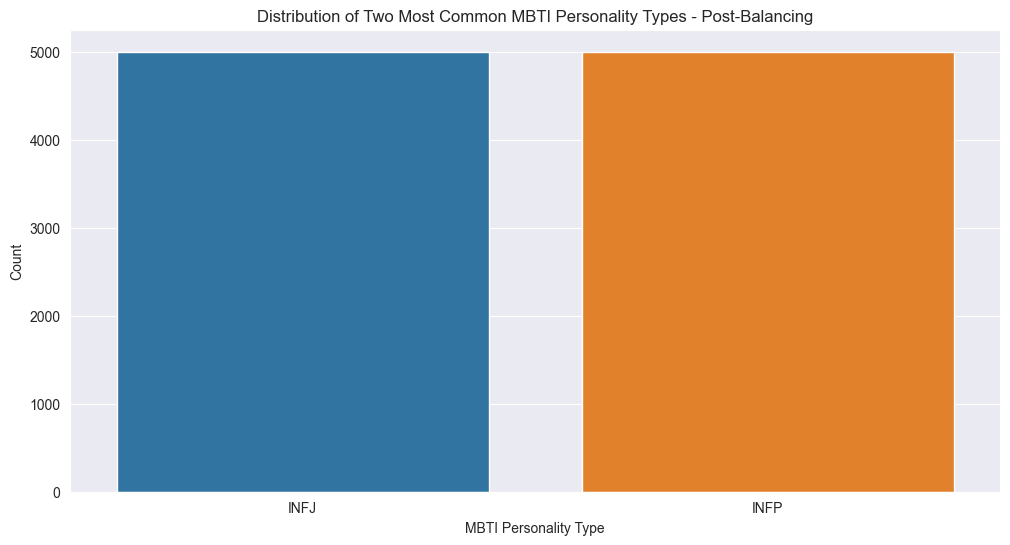

In [168]:
# Generate a graph that shows the distribution of MBTI personality types
# Set the size of the plot
plt.figure(figsize=(12, 6))

# Create a count plot for the 'type' column
sns.countplot(x='TYPE', data=balanced_df, order=balanced_df['TYPE'].value_counts().index, hue='TYPE')

# Set the title and labels
plt.title('Distribution of Two Most Common MBTI Personality Types - Post-Balancing')
plt.xlabel('MBTI Personality Type')
plt.ylabel('Count')

# Display the plot
plt.show()

In [153]:
print("Shape of the balanced dataset:", balanced_df.shape, "\n")

# Display the first few rows of the balanced dataset
print("First few rows of the balanced dataset:\n")
print(balanced_df.head())

Shape of the balanced dataset: (10000, 2) 

First few rows of the balanced dataset:

   TYPE                                              POSTS
0  INFJ                                present for my pops
1  INFP  wasnt it confirmed that she was infp i read th...
2  INFP  oh i quite like the trail if only i had more n...
3  INFP  rollar coasters are awesome cedar point for te...
4  INFP                   report sent to moderators thanks


The dataset contains two columns: TYPE and POSTS. The TYPE column contains the MBTI personality types and, as such, is categorical and is the target variable. We will encode this column to convert it into numerical values. This should make the models more efficient.

In [154]:
# Encode the labels
encoder = LabelEncoder()
balanced_df['TYPE_ENCODED'] = encoder.fit_transform(balanced_df['TYPE'])

### Model Training

Holdout cross-validation will be used: models will be trained on the training set and validated on the test set.

GridSearchCV evaluated models using the accuracy score, fine-tuning each model's hyperparameters to optimize this metric.

Accuracy is appropriate since we have a balanced dataset. It measures the proportion of correctly predicted observations out of the total observations and is calculated as (True Positive count + True Negative count) / (Total count).

$$
\frac{TP + TN}{TP + TN + FP + FN}
$$

It was decided to evaluate two approaches towards feature representation, namely SentenceTransformer and TfidfVectorizer. SentenceTransformer provides semantic understanding and context awareness, such as sentiment analysis or detecting nuanced similarities between texts.
TfidfVectorizer, on the other hand, measures term importance and frequency. Evaluating both approaches allows for a comprehensive assessment of feature representations, helping to identify the most effective approach for improving model accuracy and performance across various text classification tasks. This dual evaluation ensures that models are robust, contextually aware, and capable of capturing both semantic meaning and term importance.

#### SentenceTransformer Approach

- Generate sentence embeddings using a pretrained SentenceTransformer model.
- Split data into training and testing sets.
- Define models (Logistic Regression, SVC, Decision Tree, Naive Bayes, RandomForest) and their hyperparameters.
- Perform hyperparameter tuning using GridSearchCV.
- Evaluate models.

Generate sentence embeddings from POSTS using pretrained SentenceTransformer model.

In [155]:
# Initialize the SentenceTransformer model
model_sntrnfrmr = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# Convert the POSTS column to a list
posts_list = balanced_df['POSTS'].tolist()

# Generate sentence embeddings
sentence_embeddings = model_sntrnfrmr.encode(posts_list)

# Convert the embeddings to a DataFrame
embeddings_df = pd.DataFrame(sentence_embeddings)

# Combine the TYPE_ENCODED column with the embeddings
result_df = pd.concat([balanced_df['TYPE_ENCODED'], embeddings_df], axis=1)

# Display the head of the resulting dataset
print(result_df.head())

   TYPE_ENCODED         0         1         2         3         4         5  \
0             0 -0.774743 -0.152703  0.796665 -0.354105  0.197674  0.374386   
1             1  0.087105 -0.050557 -0.167665  0.378613  0.082485  0.082450   
2             1  0.557265 -0.307442  0.517207  0.567678  0.295903 -0.376131   
3             1 -0.233488 -0.167444  0.014595  0.009752 -0.767306  0.056552   
4             1 -0.281143  0.032688 -0.005040 -0.186827 -0.040808  0.249121   

          6         7         8  ...       374       375       376       377  \
0  0.591729  0.162300 -0.235881  ...  0.521910  0.171451  0.642649  0.433369   
1  0.592965  0.437668  0.354211  ... -0.043291  0.055931  0.119329 -0.042806   
2 -0.438765 -0.243381 -0.178956  ...  0.195713  0.150569 -0.311357 -0.161387   
3  0.636247 -0.069312  0.266016  ...  0.300779 -0.160514  0.007275 -0.153339   
4 -0.160429  0.100303 -0.224616  ... -0.240753 -0.199286  0.447677  0.115693   

        378       379       380       381   

Separate data into independent and target variables. Then create training and testing datasets, and define a set of models with their hyperparameters for hyperparameter tuning using GridSearchCV.

In [156]:
# Separate data into independent and target variables
X_sntrnfrmr = embeddings_df
y_sntrnfrmr = balanced_df['TYPE_ENCODED']

# Split the data into training and testing sets
X_sntrnfrmr_train, X_sntrnfrmr_test, y_sntrnfrmr_train, y_sntrnfrmr_test = train_test_split(X_sntrnfrmr, y_sntrnfrmr, test_size=0.2, random_state=42)

# Define the models and their hyperparameters for GridSearchCV
models_sntrnfrmr = {
    'SentenceTransformer - Logistic Regression': (LogisticRegression(), {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }),
    'SentenceTransformer - SVC': (SVC(), {
        'kernel': ['linear', 'rbf']
    }),
    'SentenceTransformer - Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [10, 50, None],
        'min_samples_split': [2, 10, 20]
    }),
    'SentenceTransformer - Naive Bayes': (GaussianNB(), {
    }),
    'SentenceTransformer - RandomForest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 50, None],
        'min_samples_split': [2, 10, 20]
    })
}

Perform hyperparameter tuning for multiple machine learning models using GridSearchCV, evaluate their performance, and store the results. This involves training the models, measuring training time, and calculating evaluation metrics like accuracy, recall, F1 score, and confusion matrix.

In [157]:
# Perform GridSearchCV to find optimum parameters for each model
results_sntrnfrmr = {
    'model': [],
    'speed': [],
    'best_params': [],
    'accuracy': [],
    'recall': [],
    'f1': [],
    'confusion_matrix': []
}

for model_name, (model, params) in models_sntrnfrmr.items():
    start_time_sntrnfrmr = time.time()
    grid_search_sntrnfrmr = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1)
    grid_search_sntrnfrmr.fit(X_sntrnfrmr_train, y_sntrnfrmr_train)
    end_time_sntrnfrmr = time.time()

    best_model_sntrnfrmr = grid_search_sntrnfrmr.best_estimator_
    y_sntrnfrmr_pred = best_model_sntrnfrmr.predict(X_sntrnfrmr_test)

    accuracy_sntrnfrmr = accuracy_score(y_sntrnfrmr_test, y_sntrnfrmr_pred)
    recall_sntrnfrmr = recall_score(y_sntrnfrmr_test, y_sntrnfrmr_pred, average='weighted')
    f1_sntrnfrmr = f1_score(y_sntrnfrmr_test, y_sntrnfrmr_pred, average='weighted')
    cm_sntrnfrmr = confusion_matrix(y_sntrnfrmr_test, y_sntrnfrmr_pred)
    report_sntrnfrmr = classification_report(y_sntrnfrmr_test, y_sntrnfrmr_pred)

    results_sntrnfrmr['model'].append(model_name)
    results_sntrnfrmr['speed'].append(end_time_sntrnfrmr - start_time_sntrnfrmr)
    results_sntrnfrmr['best_params'].append(grid_search_sntrnfrmr.best_params_)
    results_sntrnfrmr['accuracy'].append(accuracy_sntrnfrmr)
    results_sntrnfrmr['recall'].append(recall_sntrnfrmr)
    results_sntrnfrmr['f1'].append(f1_sntrnfrmr)
    results_sntrnfrmr['confusion_matrix'].append(cm_sntrnfrmr)

    print(model_name + ' best params: ', str(grid_search_sntrnfrmr.best_params_), '\n')
    print(model_name + ' Accuracy: ' + str(accuracy_sntrnfrmr))
    print(model_name + ' Classification Report:\n' + report_sntrnfrmr)

results_sntrnfrmr_df = pd.DataFrame(results_sntrnfrmr).set_index('model')  

Fitting 5 folds for each of 4 candidates, totalling 20 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

SentenceTransformer - Logistic Regression best params:  {'penalty': 'l1', 'solver': 'liblinear'} 

SentenceTransformer - Logistic Regression Accuracy: 0.529
SentenceTransformer - Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.54      0.53       987
           1       0.54      0.52      0.53      1013

    accuracy                           0.53      2000
   macro avg       0.53      0.53      0.53      2000
weighted avg       0.53      0.53      0.53      2000

Fitting 5 folds for each of 2 candidates, totalling 10 fits
SentenceTransformer - SVC best params:  {'kernel': 'rbf'} 

SentenceTransformer - SVC Accuracy: 0.5525
SentenceTransformer - SVC Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.54      0.54       987
           1       0.56      0.56      0.56      1013

    accuracy                           0.55      2000
   macro avg       0.

Show results for models using SentenceTransformer approach.

In [158]:
# Display the results
results_sntrnfrmr_df

,speed,best_params,accuracy,recall,f1,confusion_matrix
model,,,,,,
SentenceTransformer - Logistic Regression,5.541228,"{'penalty': 'l1', 'solver': 'liblinear'}",0.5290,0.5290,0.528958,"[[534, 453], [489, 524]]"
SentenceTransformer - SVC,33.494465,{'kernel': 'rbf'},0.5525,0.5525,0.552454,"[[534, 453], [442, 571]]"
SentenceTransformer - Decision Tree,15.428351,"{'max_depth': 50, 'min_samples_split': 10}",0.5405,0.5405,0.540497,"[[527, 460], [459, 554]]"
SentenceTransformer - Naive Bayes,0.168367,{},0.5335,0.5335,0.530365,"[[609, 378], [555, 458]]"
SentenceTransformer - RandomForest,348.468205,"{'max_depth': 50, 'min_samples_split': 10, 'n_...",0.5685,0.5685,0.568155,"[[533, 454], [409, 604]]"


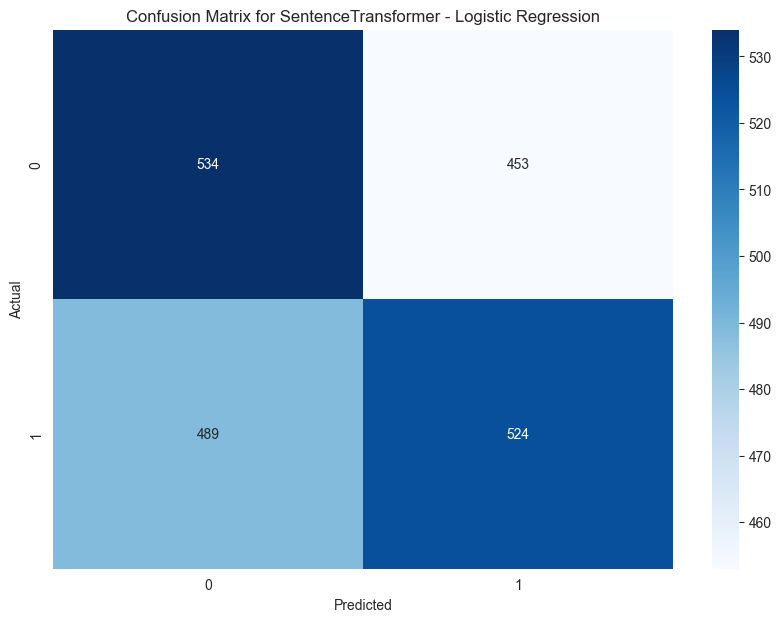

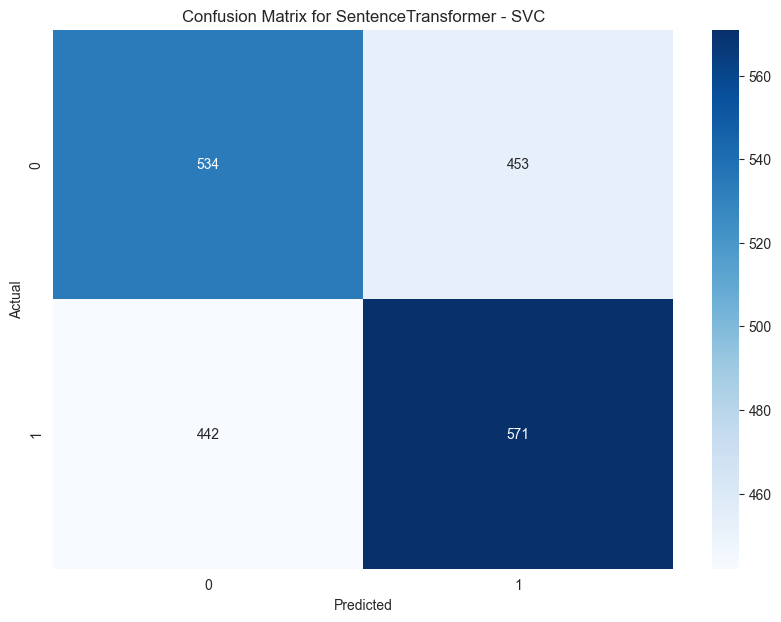

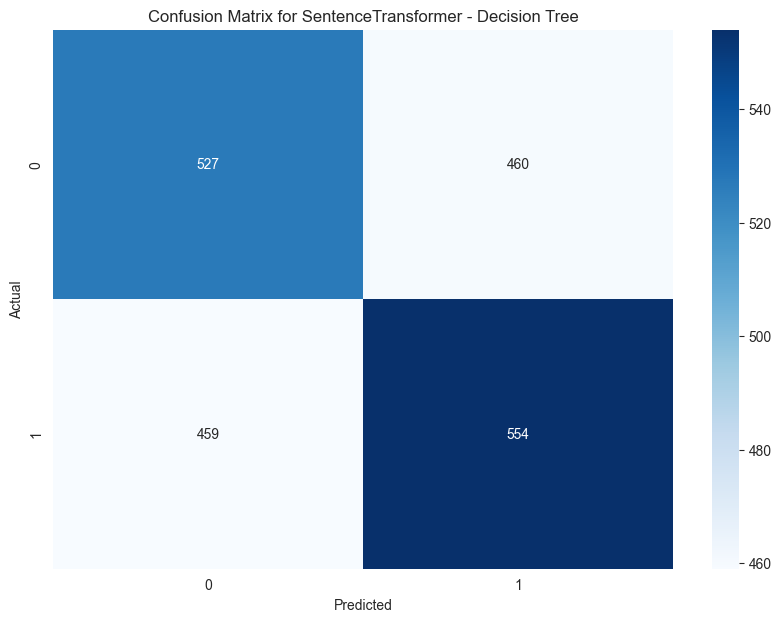

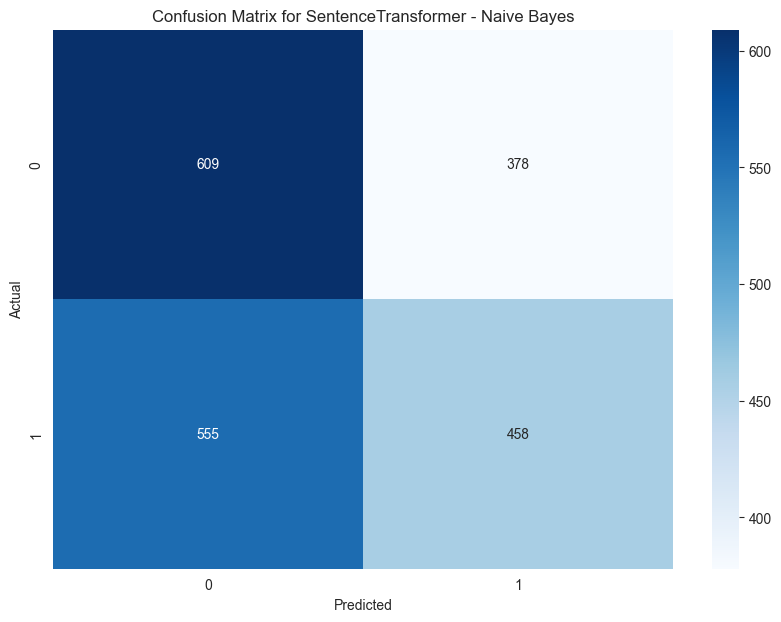

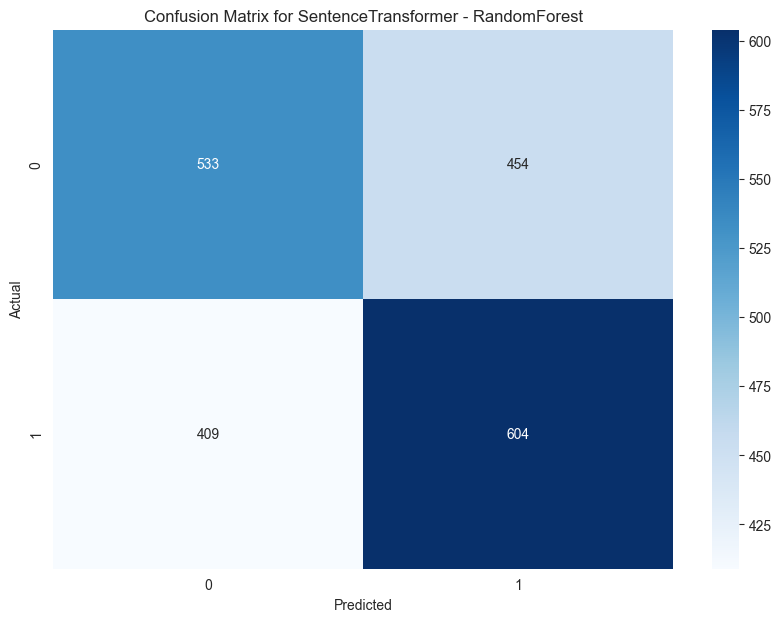

In [161]:
# Plot confusion matrices for models using SentenceTransformer approach
for model_name, cm in zip(results_sntrnfrmr_df.index, results_sntrnfrmr_df['confusion_matrix']):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

#### WordNet Lemmatization + TF-IDF Vectorization Approach

- Lemmatize the POSTS column.
- Convert posts to TF-IDF vectors.
- Split data into training and testing sets.
- Define models and their hyperparameters.
- Perform hyperparameter tuning using GridSearchCV.
- Evaluate models.

Perform lemmatization on the contents of the POSTS column. This converts words to their base forms while considering their parts of speech.

In [162]:
# Function to get the part of speech tag for lemmatization
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Lemmatize the POSTS column
balanced_df['POSTS'] = balanced_df['POSTS'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(x)]))

Separate data into independent and target variables. Then create training and testing datasets, and define a set of models with their hyperparameters for hyperparameter tuning using GridSearchCV.

In [163]:
# Preprocess the text data
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_tfidf = vectorizer.fit_transform(balanced_df['POSTS'])
y_tfidf = balanced_df['TYPE_ENCODED']

# Split the data into training and testing sets
X_tfidf_train, X_tfidf_test, y_tfidf_train, y_tfidf_test = train_test_split(X_tfidf, y_tfidf, test_size=0.2, random_state=42)

# Define the models and their hyperparameters for GridSearchCV
models_tfidf = {
    'Lemmatization + TF-IDF - Logistic Regression': (LogisticRegression(), {
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }),
    'Lemmatization + TF-IDF - SVC': (SVC(), {
        'kernel': ['linear', 'rbf']
    }),
    'Lemmatization + TF-IDF - Decision Tree': (DecisionTreeClassifier(), {
        'max_depth': [10, 50, None],
        'min_samples_split': [2, 10, 20]
    }),
    'Lemmatization + TF-IDF - Naive Bayes': (MultinomialNB(), {
        'alpha': [0.1, 1, 10]
    }),
    'Lemmatization + TF-IDF - RandomForest': (RandomForestClassifier(), {
        'n_estimators': [100, 200, 500],
        'max_depth': [10, 50, None],
        'min_samples_split': [2, 10, 20]
    })
}

Perform hyperparameter tuning for multiple machine learning models using GridSearchCV, evaluate their performance, and store the results. This involves training the models, measuring training time, and calculating evaluation metrics like accuracy, recall, F1 score, and confusion matrix.

In [165]:
# Perform GridSearchCV to find optimum parameters for each model
results_tfidf = {
    'model': [],
    'speed': [],
    'best_params': [],
    'accuracy': [],
    'recall': [],
    'f1': [],
    'confusion_matrix': []
}

for model_name, (model, params) in models_tfidf.items(): 
    start_time_tfidf = time.time()
    grid_search_tfidf = GridSearchCV(model, params, cv=5, n_jobs=-1, verbose=1)
    grid_search_tfidf.fit(X_tfidf_train, y_tfidf_train)
    end_time_tfidf = time.time()

    best_model_tfidf = grid_search_tfidf.best_estimator_
    y_tfidf_pred = best_model_tfidf.predict(X_tfidf_test)

    accuracy_tfidf = accuracy_score(y_tfidf_test, y_tfidf_pred)
    recall_tfidf = recall_score(y_tfidf_test, y_tfidf_pred, average='weighted')
    f1_tfidf = f1_score(y_tfidf_test, y_tfidf_pred, average='weighted')
    cm_tfidf = confusion_matrix(y_tfidf_test, y_tfidf_pred)
    report_tfidf = classification_report(y_tfidf_test, y_tfidf_pred)

    results_tfidf['model'].append(model_name)
    results_tfidf['speed'].append(end_time_tfidf - start_time_tfidf)
    results_tfidf['best_params'].append(grid_search_tfidf.best_params_)
    results_tfidf['accuracy'].append(accuracy_tfidf)
    results_tfidf['recall'].append(recall_tfidf)
    results_tfidf['f1'].append(f1_tfidf)
    results_tfidf['confusion_matrix'].append(cm_tfidf)

    print(model_name + ' best params: ', str(grid_search_tfidf.best_params_), '\n')
    print(model_name + ' Accuracy: ' + str(accuracy_tfidf))
    print(model_name + ' Classification Report:\n' + report_tfidf)

    results_tfidf_df = pd.DataFrame(results_tfidf).set_index('model')

Fitting 5 folds for each of 4 candidates, totalling 20 fits


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Lemmatization + TF-IDF - Logistic Regression best params:  {'penalty': 'l1', 'solver': 'saga'} 

Lemmatization + TF-IDF - Logistic Regression Accuracy: 0.5535
Lemmatization + TF-IDF - Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.45      0.50       987
           1       0.55      0.65      0.60      1013

    accuracy                           0.55      2000
   macro avg       0.55      0.55      0.55      2000
weighted avg       0.55      0.55      0.55      2000

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Lemmatization + TF-IDF - SVC best params:  {'kernel': 'rbf'} 

Lemmatization + TF-IDF - SVC Accuracy: 0.5735
Lemmatization + TF-IDF - SVC Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.54      0.55       987
           1       0.57      0.61      0.59      1013

    accuracy                           0.57      2000
   macr

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Lemmatization + TF-IDF - RandomForest best params:  {'max_depth': None, 'min_samples_split': 20, 'n_estimators': 200} 

Lemmatization + TF-IDF - RandomForest Accuracy: 0.5605
Lemmatization + TF-IDF - RandomForest Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.52      0.54       987
           1       0.56      0.60      0.58      1013

    accuracy                           0.56      2000
   macro avg       0.56      0.56      0.56      2000
weighted avg       0.56      0.56      0.56      2000



Show results for models using WordNet Lemmatization + TF-IDF approach.

In [132]:
results_tfidf_df

,speed,best_params,accuracy,recall,f1,confusion_matrix
model,,,,,,
Lemmatization + TF-IDF Logistic Regression,1.895791,"{'penalty': 'l1', 'solver': 'saga'}",0.5535,0.5535,0.548725,"[[444, 543], [350, 663]]"
Lemmatization + TF-IDF SVC,7.588776,{'kernel': 'rbf'},0.5735,0.5735,0.572964,"[[531, 456], [397, 616]]"
Lemmatization + TF-IDF Decision Tree,2.613449,"{'max_depth': None, 'min_samples_split': 2}",0.5710,0.5710,0.570961,"[[576, 411], [447, 566]]"
Lemmatization + TF-IDF Naive Bayes,0.028872,{'alpha': 10},0.5670,0.5670,0.566561,"[[593, 394], [472, 541]]"
Lemmatization + TF-IDF RandomForest,80.851408,"{'max_depth': None, 'min_samples_split': 10, '...",0.5665,0.5665,0.566046,"[[527, 460], [407, 606]]"


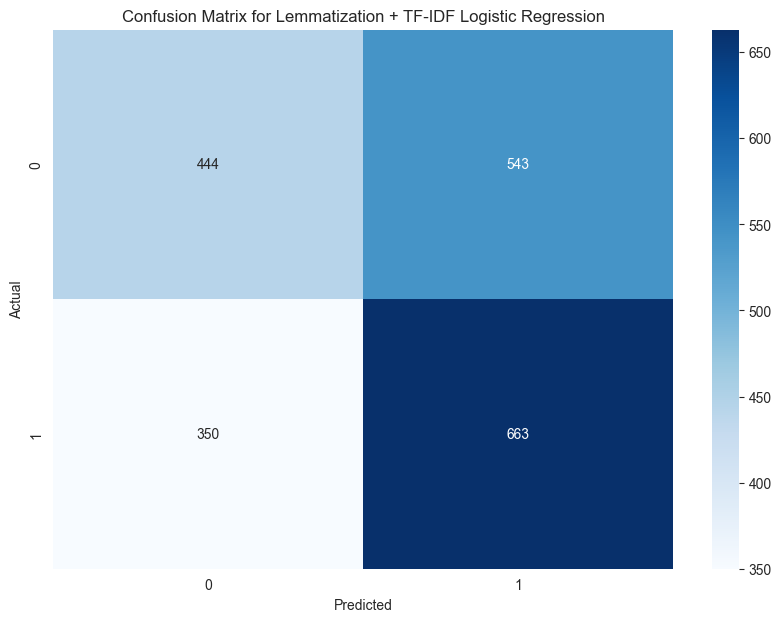

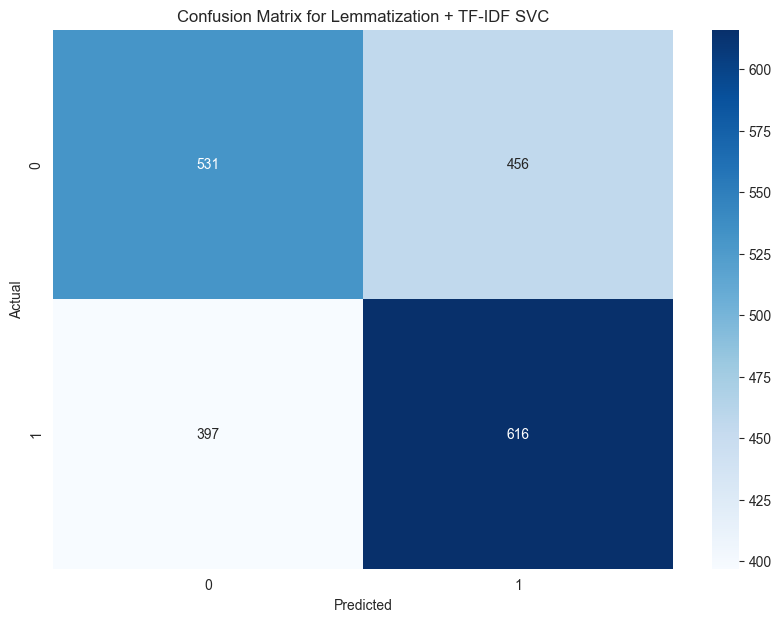

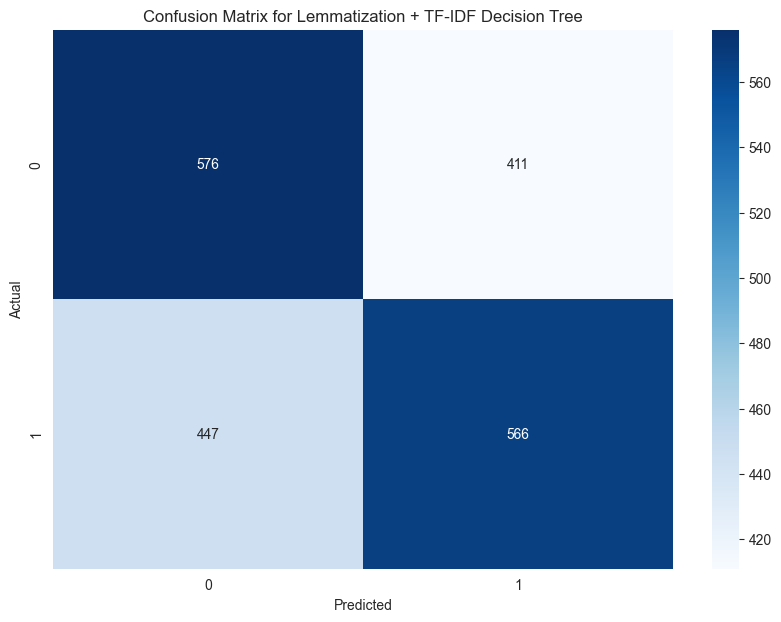

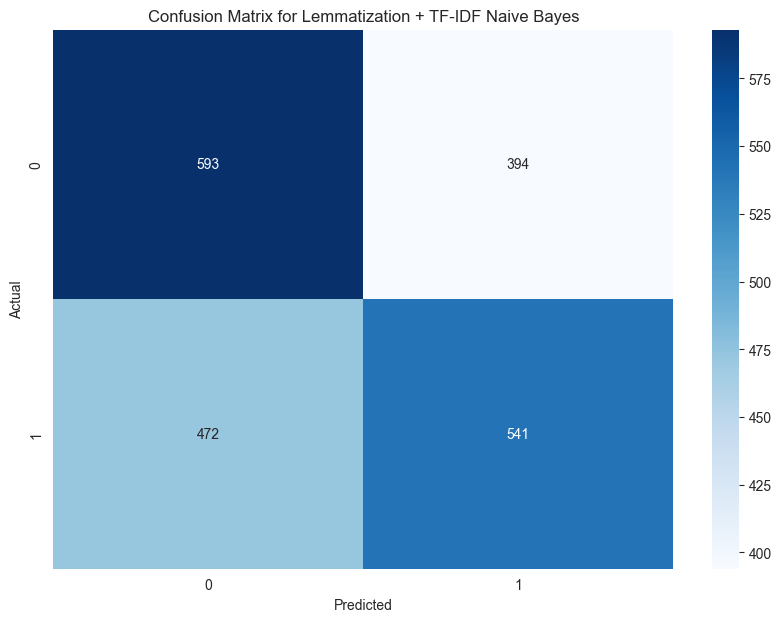

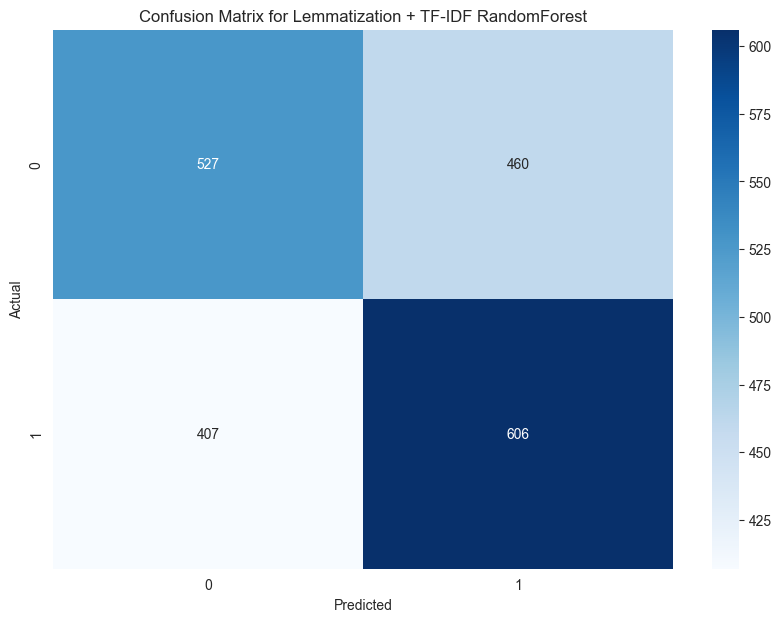

In [134]:
# Plot confusion matrices for models using WordNet Lemmatization + TF-IDF approach
for model_name, cm in zip(results_tfidf_df.index, results_tfidf_df['confusion_matrix']):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
